COLAB SERVER INSTALLATIONS

In [2]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q scikit-multilearn

     |████████████████████████████████| 89 kB 5.0 MB/s 


LIBRARIES

In [3]:
from google.colab import files
from google.colab import drive

In [4]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [5]:
#Import wrangling libraries
import pandas as pd
import datetime
import numpy as np

#import scipy
from sklearn.decomposition import PCA
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from calendar import monthrange

In [21]:
#Import ML libraries
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#from sklearn import metrics
import sklearn.metrics as metrics
from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

FUNCTION DEFINITIONS

In [18]:
#Data Import

def data_importer():
    crime_path = "/content/drive/MyDrive/Colab Notebooks/raw_data/PE_only_relevant_suburbs.csv"
    somic_path = "/content/drive/MyDrive/Colab Notebooks/raw_data/interpolate.csv"
    weather_path = "/content/drive/MyDrive/Colab Notebooks/raw_data/pe_weather_data_all.xls"

    #Crime data
    global_crime_df = pd.read_csv(crime_path, skipinitialspace=True, usecols=['OFFENCE_DESCRIPTION','DATE_COMMITED','SUBURB_FINAL'])
    
    #Socio-economic data
    global_somic_df = pd.read_csv(somic_path)
    xls = pd.ExcelFile(weather_path)

    #Weather data
    df1 = pd.read_excel(xls, 'Sheet1')
    df2 = pd.read_excel(xls, 'Sheet2')
    df3 = pd.read_excel(xls, 'Sheet3')
    global_weather_df = df1.append([df2, df3])
    global_weather_df.reset_index(drop=True, inplace=True)
    global_weather_df.drop(['ClimNo','StasName','WindDir'], axis=1 ,inplace=True)
    global_weather_df['DateT'] = pd.to_datetime(global_weather_df['DateT'])

    #Calendar data
    calendar_columns_list = ['weekday','dayom','month','last_day','first_day','holiday','pay_day']
    list_len = 7671
    start_date = '1996-01-01'
    start_year = 1996
    global_calendar_df = empty_df(list_len, calendar_columns_list,'calendar')
    global_calendar_df['weekday'] = global_calendar_df['date'].apply(lambda x: x.weekday())
    global_calendar_df['dayom'] = global_calendar_df['date'].apply(lambda x: x.day)
    global_calendar_df['month'] = global_calendar_df['date'].apply(lambda x: x.month)
    day_of_week_discrete = pd.get_dummies(global_calendar_df['weekday'], prefix='weekday')
    day_of_month_discrete = pd.get_dummies(global_calendar_df['dayom'], prefix='dayom')
    month_of_year_discrete = pd.get_dummies(global_calendar_df['month'], prefix = 'month')
    global_calendar_df = pd.concat([global_calendar_df,day_of_week_discrete], axis=1)
    global_calendar_df = pd.concat([global_calendar_df,day_of_month_discrete], axis=1)
    global_calendar_df = pd.concat([global_calendar_df,month_of_year_discrete], axis=1)
    global_calendar_df = global_calendar_df.fillna(0)
    #Holidays
    za_holidays = holidays.ZA
    holidays_ = []
    years_=[]
    for i in range(start_year,2017,1):
        years_.append(i)
    for date in sorted(za_holidays(years=years_).items()):
        holidays_.append(date[0])
    global_calendar_df['pay_day'] = global_calendar_df['date'].apply(pay_day)
    global_calendar_df['holiday'] = global_calendar_df['date'].apply(holidayer, args=(holidays_, ))
    global_calendar_df['first_day'] = global_calendar_df['date'].apply(first_day)
    global_calendar_df['last_day'] = global_calendar_df['date'].apply(Last_day)
    global_calendar_df = global_calendar_df.fillna(0)
    global_calendar_df = global_calendar_df[global_calendar_df.columns.difference(['weekday','dayom','month',])]

    return global_crime_df, global_somic_df, global_weather_df, global_calendar_df

In [8]:
#PRESENTATION METHODS

def min_max_printer(df):
    print('max')
    print(df.max())
    print()
    print('min')
    print(df.min())
    print()
    print()
    print('mean')
    print(df.mean())
    print()
    print()
    for col in df:
        df[col].plot()
        
def show_class_balance(s, show_negative_class):
    #print(s)
    non_zero_perc =  s[s == 0].count()/len(s.index)
    non_zero_perc = 1 - non_zero_perc
    non_zero_perc = round(non_zero_perc*100)
    #print('1: ')
    print(non_zero_perc.astype(int))
    if(show_negative_class):
        print()
        print()
        print('0: ')
        print(100-non_zero_perc)
        
def pca_plot(scaled_df):
    scaled_df = feature_df.copy()
    pcamodel = PCA(n_components=scaled_df.shape[1])
    pcamodel.fit(scaled_df)
    
    range_l = range(1,len(pcamodel.explained_variance_ratio_ )+1)
    bar_1 = pcamodel.explained_variance_ratio_
    bar_2 = np.cumsum(pcamodel.explained_variance_ratio_) - bar_1

    plt.bar(range_l, bar_1, edgecolor='white', width=1) #color='#7f6d5f', 
    plt.bar(range_l, bar_2, bottom=bar_1, edgecolor='white', width=1,
             label="Cumulative Explained Variance") #, color='#557f2d'

    plt.ylabel('Explained variance')
    plt.xlabel('Components')
    plt.legend(loc='upper left')
    plt.show()

In [9]:
#CALENDAR DATA CREATION FUNCTIONS

def holidayer(entry, holidays_):
    if(entry in holidays_):
        return 1
    else:
        return 0

#Payday
def pay_day(entry):
    if(entry.day == 25):
        return 1
    else:
        return 0

    #First day
def first_day(entry):
    if(entry.day == 1):
        return 1
    else:
        return 0

#Last day
def Last_day(entry):
    last_day = monthrange(entry.year, entry.month)
    if(entry.day == last_day[1]):
        return 1
    else:
        return 0

In [10]:
#SHIFT-MAPPING FUNCTIONS
#Create empty df of length equal to number of dateshifts required
def empty_df(df_length, cols, df_type):
    if(df_type=='somic'):
        empty_shape = np.zeros(shape=(df_length,len(cols))) * np.nan
        new_df = pd.DataFrame(empty_shape,columns = cols)
    elif(df_type=='calendar'):
        empty_shape = np.zeros(shape=(df_length,len(cols)))
        new_df = pd.DataFrame(empty_shape,columns = cols)
        start_date = '1996-01-01'
        new_df['date'] = pd.date_range(pd.to_datetime(start_date),periods=df_length)
        new_df['date'] = pd.to_datetime(new_df['date'])
    else:
        cols = ['central','forest_hill','humewood','south_end','st_georges','summerstrand']
        convert_dict = {'summerstrand': int, 
                        'central': int, 
                        'humewood': int, 
                        'south_end': int, 
                        'forest_hill' : int, 
                        'st_georges' : int}
        empty_shape = np.zeros(shape=(df_length,len(cols)))
        new_df = pd.DataFrame(empty_shape,columns = cols)
        new_df = new_df.astype(convert_dict)
    return new_df

def list_of_date_shifts(timeframe, no_of_shifts, df_type):
    date_shift_list = []
    last_date = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d').date()
    if(timeframe == 'recent'):
        cur_date = datetime.datetime.strptime('2007-12-31', '%Y-%m-%d').date()
    else:
        cur_date = datetime.datetime.strptime('1995-12-31', '%Y-%m-%d').date()
        
    while(cur_date <= last_date):
        for j in range(no_of_shifts):
            shift = str(cur_date) + '_shift_' + str(j+1)
            date_shift_list.append(shift)
        cur_date += datetime.timedelta(days=1)
    return date_shift_list

#Assigns a shift number to each dateime object passed to it
def assign_shift(date_time, no_of_shifts):
    div = int(24/no_of_shifts) #The smallest multiple fro this nr of shifts (8  for 3 shifts, 4 for 5 shifts)
    hour = date_time.hour
    date = date_time.date().strftime('%Y-%m-%d')
    for shift_no in range(no_of_shifts):
        shift_no = shift_no + 1 #This shift nr
        shift_hr = (shift_no)*div #This shift's latest possible hour
        if(hour < shift_hr):
            return (str(date) + '_shift_'+ str(shift_no))
        
def timespan(df, timeframe, feature_type):
    if(timeframe=='full'):
        start = '1995-12-31'
    elif(feature_type=='calendar'):
        start = '2008-01-01'
    elif(timeframe=='recent'):
        if(feature_type == 'crime'):
            start = '2008-01-01'
        else:
            start = '2007-12-31'
        
    if(feature_type=='weather'):
        df = df[(df['DateT'] >= start)]
    elif(feature_type=='crime'):
        df = df[(df['DATE_COMMITED'] >= start)]
    else:
        df = df[(df['date'] >= start)]
        
    return df

In [11]:
#LABEL FUNCTIONS

def label_shift_mapper(tmp_df,no_of_shifts, timeframe):
    tmp_df['DATE_COMMITED'] = pd.to_datetime(tmp_df['DATE_COMMITED'])
    
    tmp_df = timespan(tmp_df, timeframe, 'crime').reset_index()
    #Assign a shift to each event
    tmp_df['shift'] = tmp_df['DATE_COMMITED'].apply(assign_shift, args=(no_of_shifts, ))
    #Extract only committed time and surburb
    tmp_df = tmp_df[['DATE_COMMITED','shift','SUBURB_FINAL']]
    
    #Create list of dateshifts
    new_list = list_of_date_shifts(timeframe,no_of_shifts, 'crime')
    #print(new_list)
    #Create empty df of appropriate length containing only suburb headers
    new_df = empty_df(len(new_list), tmp_df.columns, None)
    #add new column which is list of dateshifts
    new_df['date_shift'] = new_list
    new_df.set_index('date_shift', inplace=True)

    #Records the suburb in which the event occurred (in boolean)
    dummies = pd.get_dummies(tmp_df['SUBURB_FINAL'])
    #Append the dummies columns to original tmp_df
    combine = pd.concat([tmp_df, dummies], axis=1)
    #Sum of the amount of crimes per shift
    out = combine.groupby(['shift']).sum().reset_index()
    out.set_index('shift', inplace=True)
    new_df.loc[out.index] = out
    #new_df = new_df.iloc[no_of_shifts:]
    return new_df

def label_builder(crime_df, no_of_shifts, timeframe, label_class, crime_type_label, inference):
    label_df = crime_type_builder(crime_df,crime_type_label)
    label_df = label_shift_mapper(label_df,no_of_shifts, timeframe)
    if(label_class != 'all'):
        label_df = label_df[label_class]
    if(inference == 'binary'):
        label_df = label_df.astype(bool).astype(int)
        
    if '1995-12-31_shift_1' in label_df.index:
        label_df = label_df.iloc[no_of_shifts:]
    if (('2007-12-31_shift_1' in label_df.index) and (timeframe=='recent')):
        label_df = label_df.iloc[no_of_shifts:]
    if '2017-01-01_shift_1' in label_df.index:
        label_df = label_df.iloc[:-no_of_shifts]
    return label_df

In [12]:
#DATASET FUNCTIONS


def scaled(feature_df, feature_type, scaling):
    if(feature_type=='calendar' or scaling==None or scaling == 'None'):
        return feature_df
    elif(scaling=='normalised'):
        return (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())
    elif(scaling=='standardised'):
        return (feature_df-feature_df.mean())/feature_df.std()
    
    
def crime_type_builder(global_crime_df, crime_type):
    df = global_crime_df.copy()
    if(crime_type == 'all'):
        df.drop('OFFENCE_DESCRIPTION', axis=1, inplace=True)
        return df
    elif(crime_type == 'all_wo_rape'):
        local_crime_df = df[~df['OFFENCE_DESCRIPTION'].str.contains('RAPE')]
        local_crime_df = local_crime_df[~local_crime_df['OFFENCE_DESCRIPTION'].str.contains('SEX')]
        local_crime_df = local_crime_df.sort_values(by=['DATE_COMMITED'])
    elif(crime_type == 'general_assault'):
        local_crime_df = df[df['OFFENCE_DESCRIPTION'].str.contains('ASSAULT')]
        murder_df = df[df['OFFENCE_DESCRIPTION'].str.contains('MURDER')]
        local_crime_df = local_crime_df.append(murder_df)
        local_crime_df = local_crime_df.sort_values(by=['DATE_COMMITED'])
    elif(crime_type == 'general_theft'):
        local_crime_df = df[df['OFFENCE_DESCRIPTION'].str.contains("THEFT")]
        local_crime_df = local_crime_df.sort_values(by=['DATE_COMMITED'])
    elif(crime_type == 'theft_from_car'):
        local_crime_df = df[df['OFFENCE_DESCRIPTION'].str.contains('THEFT OUT OF A MOTOR VEHICLE')]
        car_parts_theft_df = df[df['OFFENCE_DESCRIPTION'].str.contains('PARTS AND ACCESSORIES')]
        local_crime_df = local_crime_df.append(car_parts_theft_df)
        local_crime_df = local_crime_df.sort_values(by=['DATE_COMMITED'])
    elif(crime_type == 'gta'):
        local_crime_df = df[df['OFFENCE_DESCRIPTION'].str.contains('THEFT OF MOTOR VEHICLE AND MOTOR CYCLE')]
        truck_theft = df[df['OFFENCE_DESCRIPTION'].str.contains('TRUCK THEFT')]
        local_crime_df = local_crime_df.append(truck_theft)
        local_crime_df = local_crime_df.sort_values(by=['DATE_COMMITED'])
    local_crime_df.drop('OFFENCE_DESCRIPTION', axis=1, inplace=True)
    return local_crime_df


def crime_shift_mapper(tmp_df,no_of_shifts, timeframe):
    tmp_df['DATE_COMMITED'] = pd.to_datetime(tmp_df['DATE_COMMITED'])
    
    tmp_df = timespan(tmp_df, timeframe, 'crime').reset_index()
    
    #Assign a shift to each event
    tmp_df['shift'] = tmp_df['DATE_COMMITED'].apply(assign_shift, args=(no_of_shifts, ))
    #Extract only committed time and surburb
    tmp_df = tmp_df[['DATE_COMMITED','shift','SUBURB_FINAL']]
    
    #Create list of dateshifts
    new_list = list_of_date_shifts(timeframe,no_of_shifts, 'crime')
    #Create empty df of appropriate length containing only suburb headers
    new_df = empty_df(len(new_list), tmp_df.columns, None)
    #add new column which is list of dateshifts
    new_df['date_shift'] = new_list
    new_df.set_index('date_shift', inplace=True)

    #Records the suburb in which the event occurred (in boolean)
    dummies = pd.get_dummies(tmp_df['SUBURB_FINAL'])
    #Append the dummies columns to original tmp_df
    combine = pd.concat([tmp_df, dummies], axis=1)
    #Sum of the amount of crimes per shift
    out = combine.groupby(['shift']).sum().reset_index()
    out.set_index('shift', inplace=True)
    new_df.loc[out.index] = out
    new_df = new_df.shift(no_of_shifts)
    #new_df.dropna(inplace=True)
    new_df = new_df.fillna(0)
    new_df = new_df.astype(int)
    return new_df


        
def weather_shift_mapper(weather_df,no_of_shifts, timeframe):
    tmp_df = timespan(weather_df, timeframe, 'weather').reset_index()
    tmp_df = tmp_df.fillna(0)
    tmp_df['shift'] = tmp_df['DateT'].apply(assign_shift, args=(no_of_shifts, ))
    new_df = tmp_df.groupby(['shift']).mean().reset_index()
    new_df.set_index('shift',inplace=True)
    new_df.drop('index',axis=1,inplace=True)
    new_df = new_df.iloc[no_of_shifts:]
    return new_df

def somic_shift_mapper(tmp_df, no_of_shifts, timeframe):
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    tmp_df.dropna(axis = 0, how = 'all', inplace=True)

    tmp_df = timespan(tmp_df, timeframe, 'somic').reset_index()
    tmp_df['date'] = tmp_df['date'].dt.strftime('%Y-%m-%d')
    tmp_df['shift'] = tmp_df['date'] + '_shift_1'
    tmp_df.set_index('date', inplace=True)
    tmp_df.index = pd.to_datetime(tmp_df.index)
    
    list_of_dateshifts = list_of_date_shifts(timeframe,no_of_shifts,'somic')
    new_df = empty_df(len(list_of_dateshifts), tmp_df.columns, 'somic')
    new_df['shift'] = list_of_dateshifts
    new_df.set_index('shift', inplace=True)
    tmp_df.set_index('shift', inplace=True)

    new_df.loc[tmp_df.index] = tmp_df
    shift_list = new_df.index.copy()
    new_df.reset_index(drop=True, inplace=True)
    
    for col in new_df:
        new_df[col] = new_df[col].interpolate(method='polynomial', order=2)

    new_df['shift'] = shift_list
    new_df.dropna(inplace=True)
    new_df.set_index('shift', inplace=True)
    new_df.drop('index',axis=1,inplace=True)
    new_df = new_df.shift(no_of_shifts)
    new_df = new_df[:-1]
    new_df.dropna(inplace=True)
    return new_df
        


def calendar_shift_mapper(tmp_df,no_of_shifts, timeframe):
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    tmp_df['date'] = tmp_df['date'].dt.strftime('%Y-%m-%d')
    tmp_df = timespan(tmp_df, timeframe, 'calendar').reset_index()
    
    tmp_df['shift'] = tmp_df['date'] + '_shift_1'
    tmp_df.set_index('date', inplace=True)
    tmp_df.index = pd.to_datetime(tmp_df.index)
    
    list_of_dateshifts = list_of_date_shifts(timeframe,no_of_shifts,'calendar')
    
    new_df = empty_df(len(list_of_dateshifts), tmp_df.columns, 'calendar')
    new_df['shift'] = list_of_dateshifts
    new_df.set_index('shift', inplace=True)
    tmp_df.set_index('shift', inplace=True)

    
    new_df.loc[tmp_df.index] = tmp_df
    shift_list = new_df.index.copy()
    new_df.reset_index(drop=True, inplace=True)
    new_df['shift'] = shift_list
    
    new_df.set_index('shift', inplace=True)
    new_df.drop(['index','date'],axis=1,inplace=True)

    calendar_list =  new_df.values
   
    for row in range(0,len(calendar_list),no_of_shifts):
        for inc in range(no_of_shifts):
            if(inc!=0):
                calendar_list[row+inc] = calendar_list[row]
            
    final_df = pd.DataFrame(calendar_list, index =new_df.index,
                                              columns =new_df.columns)
    final_df = final_df.astype(int)
    return final_df


def feature_builder(crime_df, somic_df, weather_df, calendar_df, list_of_feature_types_, timeframe, no_of_shifts, scaling):
    list_of_dfs = []
    if('crime' in list_of_feature_types):
        list_of_dfs.append(crime_shift_mapper(crime_df, no_of_shifts, timeframe))
    if('somic' in list_of_feature_types): 
        list_of_dfs.append(somic_shift_mapper(somic_df, no_of_shifts, timeframe))
    if('weather' in list_of_feature_types):
        list_of_dfs.append(weather_shift_mapper(weather_df, no_of_shifts, timeframe))
    if('calendar' in list_of_feature_types):
        list_of_dfs.append(calendar_shift_mapper(calendar_df, no_of_shifts, timeframe))

    feature_df = list_of_dfs[0]
    list_of_dfs.pop(0)
    
    first_feature_type = list_of_feature_types_[0]
    list_of_feature_types_.pop(0)
    feature_df = scaled(feature_df, first_feature_type, scaling)

    feature_counter = 0
    for new_df in list_of_dfs:
        feature_type = list_of_feature_types[feature_counter]
        feature_counter+=1
        new_df = scaled(new_df, feature_type, scaling)
        for col in new_df:
            feature_df[col] = new_df[col]
    feature_df.dropna(inplace=True)
    if '1995-12-31_shift_1' in feature_df.index:
        feature_df = feature_df.iloc[no_of_shifts:]
    if (('2007-12-31_shift_1' in feature_df.index) and (timeframe=='recent')):
        feature_df = feature_df.iloc[no_of_shifts:]
    if '2017-01-01_shift_1' in feature_df.index:
        feature_df = feature_df.iloc[:-no_of_shifts]
    return feature_df


In [27]:
#DATASET INVOKING FUNCTIONS

def test_train_splitter(df, model_type):
    test_start = '2016-01-01'
    test_set = df[df.index >= test_start]
    train_set = df[df.index<test_start]

    return test_set,train_set

def reshaped(df, model_type):
    arr = df.values
    if(model_type == 'recurrent'):
        arr = arr.reshape(len(df),1,len(df.columns))
    return arr

#Combine all datasets into a label and feature set
def master_builder(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type):
    if('somic' in list_of_feature_types):
        print('Defaulting to "recent" timeframe as socio-economic data is included in list of features')
        timeframe = 'recent'
        
    label_df = label_builder(global_crime_df, no_of_shifts, timeframe, label_class, crime_type_label, inference)
    
    crime_df = global_crime_df
    if('crime' in list_of_feature_types):
        crime_df = crime_type_builder(global_crime_df,crime_type_feature)
    
    feature_df = feature_builder(crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, timeframe, no_of_shifts, scaling)
    
    return label_df, feature_df

In [29]:
def train_test_data(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, 
                    timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type, 
                    resampling, balance_factor, sampling_type, pcanalysis, label_class):
    
    label_df, feature_df = master_builder(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, 
                                            list_of_feature_types, timeframe, no_of_shifts, 
                                            scaling, crime_type_feature, crime_type_label, inference, model_type)

    somic_pca = False
    if(('somic' in list_of_feature_types) & (pcanalysis)):
        somic_pca = True

    if(somic_pca):
        cols_to_drop = global_somic_df.loc[:, global_somic_df.columns != 'date'].columns
        socio_df = feature_df[cols_to_drop]
        component_df =  principle_component_analysis(socio_df, scaling)
        feature_df['PC0'] = component_df['PC0']
        feature_df['PC1'] = component_df['PC1']
        feature_df['PC2'] = component_df['PC2']
        cols_to_drop = global_somic_df.loc[:, global_somic_df.columns != 'date'].columns
        feature_df = feature_df.drop(cols_to_drop, axis=1)

    X_all = feature_df.values
    y_all = label_df.values


    y_test, y_train = test_train_splitter(label_df, model_type)
    X_test, X_train = test_train_splitter(feature_df, model_type)


    if(resampling): #Only apply resampling to training labels
        y_train = resample(y_train,sampling_type,balance_factor)

    train_features = reshaped(X_train, model_type)
    train_labels = reshaped(y_train, model_type)

    test_features = reshaped(X_test, model_type)
    test_labels = reshaped(y_test, model_type)

    return train_features, train_labels, test_features, test_labels, y_train

In [33]:
#FEATURE SELECTION
          
def principle_component_analysis(feature_df, scaling):
    # You must normalize the data before applying the fit method
    scaled_df = feature_df.copy()
    pca = PCA(n_components=scaled_df.shape[1])
    pca.fit(scaled_df)

    transformed = pca.transform(scaled_df)
    transformed_df = pd.DataFrame(transformed, columns=['PC%s' % _ for _ in range(len(scaled_df.columns))],index=scaled_df.index)
    return transformed_df

def class_balance(train_lab):
    balance =  train_lab[train_lab == 0].count()/len(train_lab.index)
    balance = 1 - balance
    balance = round(balance,2)
    return balance

def resample(train_lab, sampling_type,  balance_factor):
    all_balance = class_balance(train_lab)
    for suburb in train_lab:
        balance = all_balance[suburb]
        fraction = (0.5 - balance) * balance_factor
        
        upsample = ((fraction > 0) and ( (sampling_type=='up') or (sampling_type=='updown')))
        downsample = ((fraction < 0) and ( (sampling_type=='down') or (sampling_type=='updown')))

        if( upsample ): #Needs to be upsampled
            quer = str(suburb) + ' == 0'
            train_lab.loc[train_lab.query(quer).sample(frac=fraction).index,suburb] = 1
        
        if( downsample ): #Needs to be downsampled
            fraction = fraction*-1
            quer = str(suburb) + ' == 1'
            train_lab.loc[train_lab.query(quer).sample(frac=fraction).index,suburb] = 0

    return train_lab

In [ ]:
#Custom evaluation metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

custom_metrics=['acc',f1_m,precision_m, recall_m]
#Call as model.compile(optimizer='adam',
                    #loss=loss_,
                    #metrics=custom_metrics)

In [15]:
#Evaluate predictions

def classification_results_macro(labels, predictions):
    acc = metrics.accuracy_score(test_labels, predictions)
    f1_score = metrics.f1_score(test_labels, predictions,average='macro')
    precision_score = metrics.precision_score(test_labels, predictions,average='macro')
    return {'accuracy':acc, 'precision':precision_score, 'f1':f1_score}

def classification_results_micro(labels, predictions):
    acc = 1 - metrics.hamming_loss(test_labels, predictions)
    f1_score = metrics.f1_score(test_labels, predictions,average='micro')
    precision_score = metrics.precision_score(test_labels, predictions,average='micro')
    return {'accuracy':acc, 'precision':precision_score, 'f1':f1_score}

IMPORT DATA

In [19]:
#IMPORT RAW DATASETS
global_crime_df, global_somic_df, global_weather_df, global_calendar_df = data_importer()

DATA WRANGLING AND PREPERATION

In [20]:
timeframe = 'recent'  #recent  #full
crime_type_feature = 'all_wo_rape'  #  all   all_wo_rape   general_assault    general_theft   theft_from_car    gta
scaling = 'standardised'  #'standardised'    'normalised'  None
pcanalysis = True
inference = 'binary'   # binary    #None
label_class = 'all' #  humewood   central   summerstrand   st_georges   forest_hill   south_end  all

suburbs = ['humewood','central','summerstrand','st_georges','forest_hill','south_end']

#Model type
model_type = 'forest' #recurrent   dense   forest  logreg

MODEL BUILDS

LOGISTIC REGRESSION

In [31]:
#LOG REGRESSION

no_of_shifts = 1

#Crime types
crime_type_label = 'all_wo_rape'  #  all   all_wo_rape   general_assault    general_theft   theft_from_car    gta

#feature subsets and scaling
list_of_feature_types = ['somic', 'weather', 'crime']  #'somic', 'weather', 'crime', 'calendar'

#Resampling
resampling = False  #False  True
balance_factor = 0.1
sampling_type = 'up' #down updown #up

train_features, train_labels, test_features, test_labels, y_train = train_test_data(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, 
                    timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type, 
                    resampling, balance_factor, sampling_type, pcanalysis, label_class)

show_class_balance(y_train, False)
print()

baseline = BinaryRelevance(classifier = LogisticRegression(multi_class='multinomial'))

# train
baseline.fit(train_features, train_labels)

# predict
predictions = baseline.predict(test_features).toarray()

results = classification_results_micro(test_labels, predictions)

for res in results:
    print(res + ': ' + str(results[res]))
print()
print()
print(predictions[:20])

Defaulting to "recent" timeframe as socio-economic data is included in list of features
central         98
forest_hill     17
humewood        62
south_end       32
st_georges       8
summerstrand    83
dtype: int64

accuracy: 0.8328779599271403
precision: 0.8171064604185623
f1: 0.8303282478039758


[[1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]]


RANDOM FOREST

In [34]:
#Random Forest

no_of_shifts = 2

#Crime types
crime_type_label = 'all_wo_rape'  #  all   all_wo_rape   general_assault    general_theft   theft_from_car    gta

#feature subsets and scaling
list_of_feature_types = ['somic', 'weather', 'crime']  #'somic', 'weather', 'crime', 'calendar'

#Resampling
resampling = True  #False  True
balance_factor = 0.21
sampling_type = 'up' #down updown #up

train_features, train_labels, test_features, test_labels, y_train = train_test_data(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, 
                    timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type, 
                    resampling, balance_factor, sampling_type, pcanalysis, label_class)

show_class_balance(y_train, False)
print()

sub_weights = {0:1, 1:1, 2:1, 3:1, 4:1, 5:1}
forest = RandomForestClassifier(random_state=1) #, class_weight=sub_weights
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(train_features, train_labels)
predictions = multi_target_forest.predict(test_features)

results = classification_results_micro(test_labels, predictions)

for res in results:
    print(res + ': ' + str(results[res]))
print()
print()
print(predictions[:20])

Defaulting to "recent" timeframe as socio-economic data is included in list of features
central         84
forest_hill     16
humewood        40
south_end       23
st_georges      14
summerstrand    59
dtype: int64

accuracy: 0.7622950819672132
precision: 0.6252860411899314
f1: 0.676780185758514


[[1 0 0 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]]


NUERAL NETWORKS

In [37]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

def early_stopping_callback(mon_val):
    return tf.keras.callbacks.EarlyStopping(monitor="val_" + mon_val, patience=0)  #monitor='val_categorical_accuracy'

epoch_dots_callback = tfdocs.modeling.EpochDots()

DENSE NEURAL NETWORK

Defaulting to "recent" timeframe as socio-economic data is included in list of features
central         98
forest_hill     17
humewood        62
south_end       32
st_georges       8
summerstrand    83
dtype: int64


Epoch: 0, categorical_accuracy:0.9772,  loss:0.6009,  val_categorical_accuracy:0.9761,  val_loss:0.5625,  
..

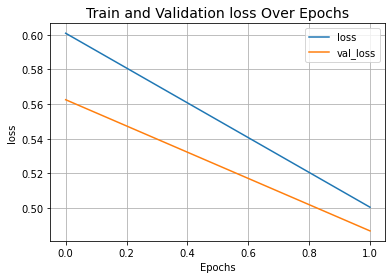

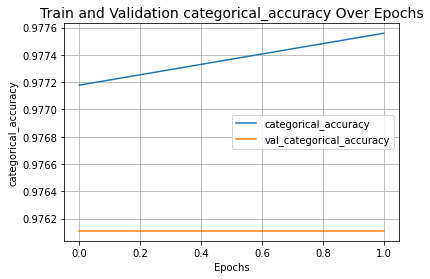

In [56]:
#DATA#
################################################################################################################
no_of_shifts = 1

#Crime types
crime_type_label = 'all_wo_rape'  #  all   all_wo_rape   general_assault    general_theft   theft_from_car    gta

#feature subsets and scaling
list_of_feature_types = ['somic', 'weather', 'crime']  #'somic', 'weather', 'crime', 'calendar'

#Resampling
resampling = False  #False  True
balance_factor = 0.1
sampling_type = 'up' #down updown #up

model_type = 'dense'

train_features, train_labels, test_features, test_labels, y_train = train_test_data(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, 
                    timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type, 
                    resampling, balance_factor, sampling_type, pcanalysis, label_class)

show_class_balance(y_train, False)
print()

#MODEL#
################################################################################################################

def dense_model(in_shape, learning_rate, optimiser, loss_, metric_, kernel_mean, kernel_std, layer_count, first_layer_node_count, node_count):
    model = keras.Sequential()

    model.add(layers.Dense(first_layer_node_count,input_shape=in_shape, activation='relu')) # input_shape=[len(x_train.keys())]
    for layer in range(layer_count):
        model.add(layers.Dense(node_count, activation='relu'))

    model.add(layers.Dense(6, activation='sigmoid')) #, activation='sigmoid'

    #opt = keras.optimizers.Adam(learning_rate=0.0001)
    #opt = keras.optimizers.SGD(lr=0.0001, nesterov=True)
    model.compile(loss= loss_,
                optimizer='adam', #opt
                metrics= metric_
                )
    return model

in_shape = (np.shape(train_features)[-1],)

metrics_ = ['categorical_accuracy'] #['categorical_accuracy']  #['acc']    #   ['acc',f1_m,precision_m, recall_m])
loss_func = 'binary_crossentropy'

layer_count = 2
node_count = 6
first_layer_node_count = node_count

learning_rate=0.0001
optimiser = 'adam'

kernel_mean = 0.00001
kernel_std = 1

EPOCHS=10

model = dense_model(in_shape, learning_rate, optimiser, loss_func, metrics_, kernel_mean, kernel_std, layer_count, first_layer_node_count, node_count)

history = model.fit(train_features, train_labels, epochs=EPOCHS, validation_split = 0.1, verbose=0,callbacks=[early_stopping_callback(metrics_[0]),epoch_dots_callback ])

plot_result("loss")
plot_result(metrics_[0])

In [45]:
predictions = model.predict(test_features)#.flatten()
predictions = predictions.reshape(len(predictions),6)
predictions = (predictions>0.5).astype(int)

results = classification_results_micro(test_labels, predictions)

for res in results:
    print(res + ': ' + str(results[res]))
print()
print()
print(predictions[:20])

accuracy: 0.8296903460837887
precision: 0.810251798561151
f1: 0.828125


[[1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]]


LSTM RECURRENT NEURAL NETWORK

Defaulting to "recent" timeframe as socio-economic data is included in list of features
central         48
forest_hill     26
humewood        30
south_end       27
st_georges      25
summerstrand    35
dtype: int64


Epoch: 0, categorical_accuracy:0.5800,  loss:0.6615,  val_categorical_accuracy:0.5753,  val_loss:0.6324,  
..

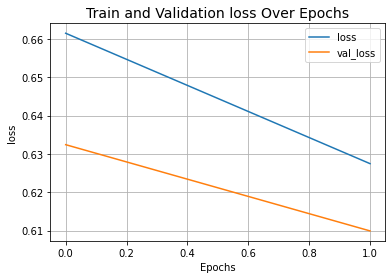

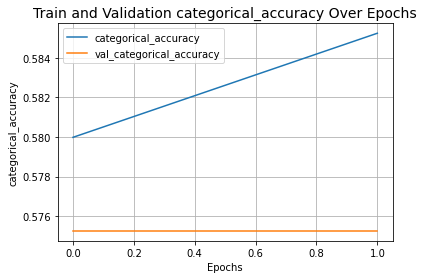

In [52]:
#DATA#
################################################################################################################
no_of_shifts = 6

#Crime types
crime_type_label = 'all_wo_rape'  #  all   all_wo_rape   general_assault    general_theft   theft_from_car    gta

#feature subsets and scaling
list_of_feature_types = ['somic', 'weather', 'crime']  #'somic', 'weather', 'crime', 'calendar'

#Resampling
resampling = True  #False  True
balance_factor = 0.5
sampling_type = 'updown' #down updown #up

model_type = 'recurrent'

train_features, train_labels, test_features, test_labels, y_train = train_test_data(global_crime_df, global_somic_df, global_weather_df, global_calendar_df, list_of_feature_types, 
                    timeframe, no_of_shifts, scaling, crime_type_feature, crime_type_label, inference, model_type, 
                    resampling, balance_factor, sampling_type, pcanalysis, label_class)

show_class_balance(y_train, False)
print()

#MODEL#
################################################################################################################

#LSTM
def recurrent_model(in_shape, learning_rate, optimiser, loss_, metric_, kernel_mean, kernel_std, layer_count, first_layer_node_count, node_count):
    model = keras.Sequential()
    
    model.add(layers.LSTM(first_layer_node_count, activation='relu', 
                            input_shape=(1,in_shape),
                            return_sequences=True, 
                            ))
    for layer in range(layer_count):
        model.add(layers.LSTM(node_count, activation='relu', return_sequences=True,))

    model.add(layers.Dense(6, activation='sigmoid')) #, activation='sigmoid'

    #opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam',
                    loss=loss_,
                    #metrics=['acc',f1_m,precision_m, recall_m])
                    metrics=metric_) #custom_metrics
    return model

in_shape = np.shape(train_features)[2]

metrics_ = ['categorical_accuracy']#['acc',f1_m,precision_m, recall_m])
loss_func = 'binary_crossentropy'

layer_count = 6
node_count = 2
first_layer_node_count = node_count

learning_rate=0.0001
optimiser = 'adam'

kernel_mean = 0.00001
kernel_std = 1

EPOCHS=10

model = recurrent_model(in_shape, learning_rate, optimiser, loss_func, metrics_, kernel_mean, kernel_std, layer_count, first_layer_node_count, node_count)

history = model.fit(train_features, train_labels, epochs=EPOCHS, validation_split = 0.1, verbose=0,callbacks=[early_stopping_callback(metrics_[0]),epoch_dots_callback ])

plot_result("loss")
plot_result(metrics_[0])

In [50]:
predictions = model.predict(test_features)#.flatten()
predictions = predictions.reshape(len(predictions),6)
test_labels = test_labels.reshape(len(predictions),6)
predictions = (predictions>0.5).astype(int)

results = classification_results_micro(test_labels, predictions)

for res in results:
    print(res + ': ' + str(results[res]))
print()
print()
print(predictions[:20])

accuracy: 0.8333333333333334
precision: 0.8178506375227687
f1: 0.8307123034227567


[[1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]]
